## Part 1
- Overview
- Demo
- Model overview
- Preloaded model & tokenizer
- Quick test

## Part 2
- Update model
- Load dataset
- Data formatting loader

## Part 3
- Training
- Testing
- Recreate demo

# Download Modules

In [1]:
# !pip install transformers sentencepiece datasets

In [2]:
from datasets import load_dataset
# from google.colab import drive
from IPython.display import display
# from IPython.html import widgets
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import os
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
!jupyter nbextension enable --py widgetsnbextension
from tqdm import notebook

sns.set()

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# drive.mount('/content/gdrive')

In [4]:
model_repo = 'google/mt5-base'
model_path = './model/mt5_translation.pt'
model_folder = './model/'
max_seq_len = 128

# Load Tokenizer & Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_repo, max_new_tokens = max_seq_len)

/home/comrade/.conda/envs/mt5_demo/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()


# Overview and Quick Test

In [7]:
token_ids = tokenizer.encode(
    '<lao> This will be translated to Laos! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids, max_new_tokens = max_seq_len)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,    492,    268,    669,   1494,    898,    390,  37194,    285,
            288, 135548,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')
tensor([[     0, 250099,    274, 116024,  11994,    271,      1]],
       device='cuda:0')
<pad> <extra_id_0> (hopefully)</s>


# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizer

In [8]:
example_input_str = '<lao> This is just a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042,  492,  268,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272,
         1982, 1315,  260,    1]])
Tokens: ['▁<', 'la', 'o', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [9]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

# Prepare Dataset

In [10]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

No config specified, defaulting to: alt/alt-parallel
Found cached dataset alt (/home/comrade/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/b498af66d7e1b78d98b7557e7b0b06ae54fc60491dccdc1a0f8316e677d1ce75)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [12]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

In [13]:
LANG_TOKEN_MAPPING = {
    'vi': '<vi>',
    'lo': '<lao>'
}

In [14]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 768)

In [15]:
torch.save(model, model_path)

In [16]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

In [17]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [18]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<lao> ▁ Ý ▁đ ã ▁đ ánh ▁b ại ▁B ồ ▁Đ ào ▁Nh a ▁v ới ▁ t ỉ ▁ s ố ▁3 1-5 ▁ ở ▁B ảng ▁C ▁Gi ải ▁v ô ▁đ ịch ▁ Rugby ▁th ế ▁gi ới ▁2007 ▁ t ại ▁Parc ▁des ▁Princes , ▁Pari , ▁P háp . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ ອິ ຕາ ລີ ໄດ້ ເສຍ ໃຫ້ ປ ໊ ອກ ຕຸ ຍ ການ ▁31 ▁ຕໍ່ ▁5 ▁ໃນ ພູ ລ ▁C ▁ຂອງ ▁ການ ແຂ່ງຂັນ ຣັ ກ ບ ີ້ ລະດັບ ໂລກ ປີ ▁2007 ▁ທີ່ ▁ ປາກ ເດ ແພ ຣັ ງ ▁ ປາ ຣີ ▁ ປະເທດ ຝ ຣ ັ່ງ . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

# Train/Finetune

In [19]:
# model.load_state_dict(torch.load(model_path), strict=False)

In [20]:
# Constants
n_epochs = 8
# batch_size = 16
batch_size = 8
print_freq = 100
checkpoint_freq = 500
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [21]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [22]:
losses = []

In [23]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [24]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in notebook.tqdm(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 1 | Step: 100 | Avg. loss: 16.827 | lr: 0.0002777777777777778
Epoch: 1 | Step: 200 | Avg. loss: 2.649 | lr: 0.0004994415903506813
Epoch: 1 | Step: 300 | Avg. loss: 2.056 | lr: 0.0004966495421040876
Epoch: 1 | Step: 400 | Avg. loss: 1.638 | lr: 0.0004938574938574939
Epoch: 1 | Step: 500 | Avg. loss: 1.446 | lr: 0.0004910654456109001
Saving model with test loss of 1.440
Epoch: 1 | Step: 600 | Avg. loss: 1.347 | lr: 0.0004882733973643065
Epoch: 1 | Step: 700 | Avg. loss: 1.242 | lr: 0.0004854813491177127
Epoch: 1 | Step: 800 | Avg. loss: 1.200 | lr: 0.00048268930087111905
Epoch: 1 | Step: 900 | Avg. loss: 1.177 | lr: 0.0004798972526245254
Epoch: 1 | Step: 1000 | Avg. loss: 1.109 | lr: 0.00047710520437793165
Saving model with test loss of 1.131
Epoch: 1 | Step: 1100 | Avg. loss: 1.124 | lr: 0.00047431315613133797
Epoch: 1 | Step: 1200 | Avg. loss: 1.038 | lr: 0.0004715211078847443
Epoch: 1 | Step: 1300 | Avg. loss: 1.047 | lr: 0.00046872905963815057
Epoch: 1 | Step: 1400 | Avg. loss

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 2 | Step: 100 | Avg. loss: 0.868 | lr: 0.0004391054277417914
Epoch: 2 | Step: 200 | Avg. loss: 0.843 | lr: 0.00043631337949519766
Epoch: 2 | Step: 300 | Avg. loss: 0.860 | lr: 0.000433521331248604
Epoch: 2 | Step: 400 | Avg. loss: 0.828 | lr: 0.0004307292830020103
Epoch: 2 | Step: 500 | Avg. loss: 0.845 | lr: 0.0004279372347554166
Saving model with test loss of 0.860
Epoch: 2 | Step: 600 | Avg. loss: 0.852 | lr: 0.0004251451865088229
Epoch: 2 | Step: 700 | Avg. loss: 0.819 | lr: 0.0004223531382622291
Epoch: 2 | Step: 800 | Avg. loss: 0.866 | lr: 0.00041956109001563545
Epoch: 2 | Step: 900 | Avg. loss: 0.828 | lr: 0.0004167690417690418
Epoch: 2 | Step: 1000 | Avg. loss: 0.801 | lr: 0.00041397699352244805
Saving model with test loss of 0.936
Epoch: 2 | Step: 1100 | Avg. loss: 0.818 | lr: 0.0004111849452758544
Epoch: 2 | Step: 1200 | Avg. loss: 0.801 | lr: 0.0004083928970292607
Epoch: 2 | Step: 1300 | Avg. loss: 0.842 | lr: 0.000405600848782667
Epoch: 2 | Step: 1400 | Avg. loss: 0.

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 3 | Step: 100 | Avg. loss: 0.735 | lr: 0.0003759772168863078
Epoch: 3 | Step: 200 | Avg. loss: 0.698 | lr: 0.00037318516863971406
Epoch: 3 | Step: 300 | Avg. loss: 0.735 | lr: 0.0003703931203931204
Epoch: 3 | Step: 400 | Avg. loss: 0.705 | lr: 0.0003676010721465267
Epoch: 3 | Step: 500 | Avg. loss: 0.708 | lr: 0.000364809023899933
Saving model with test loss of 0.937
Epoch: 3 | Step: 600 | Avg. loss: 0.697 | lr: 0.0003620169756533393
Epoch: 3 | Step: 700 | Avg. loss: 0.724 | lr: 0.00035922492740674564
Epoch: 3 | Step: 800 | Avg. loss: 0.734 | lr: 0.00035643287916015186
Epoch: 3 | Step: 900 | Avg. loss: 0.714 | lr: 0.0003536408309135582
Epoch: 3 | Step: 1000 | Avg. loss: 0.733 | lr: 0.0003508487826669645
Saving model with test loss of 0.818
Epoch: 3 | Step: 1100 | Avg. loss: 0.719 | lr: 0.0003480567344203708
Epoch: 3 | Step: 1200 | Avg. loss: 0.729 | lr: 0.0003452646861737771
Epoch: 3 | Step: 1300 | Avg. loss: 0.736 | lr: 0.0003424726379271834
Epoch: 3 | Step: 1400 | Avg. loss: 0

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 4 | Step: 100 | Avg. loss: 0.620 | lr: 0.00031284900603082425
Epoch: 4 | Step: 200 | Avg. loss: 0.618 | lr: 0.0003100569577842305
Epoch: 4 | Step: 300 | Avg. loss: 0.613 | lr: 0.0003072649095376368
Epoch: 4 | Step: 400 | Avg. loss: 0.635 | lr: 0.0003044728612910431
Epoch: 4 | Step: 500 | Avg. loss: 0.620 | lr: 0.0003016808130444494
Saving model with test loss of 0.873
Epoch: 4 | Step: 600 | Avg. loss: 0.623 | lr: 0.0002988887647978557
Epoch: 4 | Step: 700 | Avg. loss: 0.636 | lr: 0.00029609671655126204
Epoch: 4 | Step: 800 | Avg. loss: 0.633 | lr: 0.00029330466830466826
Epoch: 4 | Step: 900 | Avg. loss: 0.643 | lr: 0.0002905126200580746
Epoch: 4 | Step: 1000 | Avg. loss: 0.635 | lr: 0.0002877205718114809
Saving model with test loss of 0.935
Epoch: 4 | Step: 1100 | Avg. loss: 0.617 | lr: 0.0002849285235648872
Epoch: 4 | Step: 1200 | Avg. loss: 0.619 | lr: 0.0002821364753182935
Epoch: 4 | Step: 1300 | Avg. loss: 0.621 | lr: 0.00027934442707169984
Epoch: 4 | Step: 1400 | Avg. loss:

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 5 | Step: 100 | Avg. loss: 0.558 | lr: 0.00024972079517534065
Epoch: 5 | Step: 200 | Avg. loss: 0.520 | lr: 0.0002469287469287469
Epoch: 5 | Step: 300 | Avg. loss: 0.541 | lr: 0.00024413669868215325
Epoch: 5 | Step: 400 | Avg. loss: 0.555 | lr: 0.00024134465043555952
Epoch: 5 | Step: 500 | Avg. loss: 0.561 | lr: 0.00023855260218896582
Saving model with test loss of 0.757
Epoch: 5 | Step: 600 | Avg. loss: 0.547 | lr: 0.00023576055394237215
Epoch: 5 | Step: 700 | Avg. loss: 0.570 | lr: 0.00023296850569577842
Epoch: 5 | Step: 800 | Avg. loss: 0.545 | lr: 0.00023017645744918472
Epoch: 5 | Step: 900 | Avg. loss: 0.557 | lr: 0.00022738440920259102
Epoch: 5 | Step: 1000 | Avg. loss: 0.554 | lr: 0.00022459236095599734
Saving model with test loss of 0.886
Epoch: 5 | Step: 1100 | Avg. loss: 0.555 | lr: 0.00022180031270940362
Epoch: 5 | Step: 1200 | Avg. loss: 0.552 | lr: 0.00021900826446280992
Epoch: 5 | Step: 1300 | Avg. loss: 0.555 | lr: 0.00021621621621621624
Epoch: 5 | Step: 1400 | Av

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 6 | Step: 100 | Avg. loss: 0.502 | lr: 0.00018659258431985703
Epoch: 6 | Step: 200 | Avg. loss: 0.492 | lr: 0.00018380053607326336
Epoch: 6 | Step: 300 | Avg. loss: 0.512 | lr: 0.00018100848782666966
Epoch: 6 | Step: 400 | Avg. loss: 0.504 | lr: 0.00017821643958007593
Epoch: 6 | Step: 500 | Avg. loss: 0.505 | lr: 0.00017542439133348225
Saving model with test loss of 0.921
Epoch: 6 | Step: 600 | Avg. loss: 0.496 | lr: 0.00017263234308688855
Epoch: 6 | Step: 700 | Avg. loss: 0.515 | lr: 0.00016984029484029485
Epoch: 6 | Step: 800 | Avg. loss: 0.520 | lr: 0.00016704824659370112
Epoch: 6 | Step: 900 | Avg. loss: 0.485 | lr: 0.00016425619834710745
Epoch: 6 | Step: 1000 | Avg. loss: 0.513 | lr: 0.00016146415010051375
Saving model with test loss of 1.005
Epoch: 6 | Step: 1100 | Avg. loss: 0.489 | lr: 0.00015867210185392002
Epoch: 6 | Step: 1200 | Avg. loss: 0.501 | lr: 0.00015588005360732635
Epoch: 6 | Step: 1300 | Avg. loss: 0.528 | lr: 0.00015308800536073265
Epoch: 6 | Step: 1400 | A

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 7 | Step: 100 | Avg. loss: 0.397 | lr: 0.00012346437346437346
Epoch: 7 | Step: 200 | Avg. loss: 0.417 | lr: 0.00012067232521777976
Epoch: 7 | Step: 300 | Avg. loss: 0.398 | lr: 0.00011788027697118607
Epoch: 7 | Step: 400 | Avg. loss: 0.412 | lr: 0.00011508822872459236
Epoch: 7 | Step: 500 | Avg. loss: 0.422 | lr: 0.00011229618047799867
Saving model with test loss of 0.860
Epoch: 7 | Step: 600 | Avg. loss: 0.412 | lr: 0.00010950413223140496
Epoch: 7 | Step: 700 | Avg. loss: 0.423 | lr: 0.00010671208398481126
Epoch: 7 | Step: 800 | Avg. loss: 0.414 | lr: 0.00010392003573821756
Epoch: 7 | Step: 900 | Avg. loss: 0.427 | lr: 0.00010112798749162385
Epoch: 7 | Step: 1000 | Avg. loss: 0.422 | lr: 9.833593924503017e-05
Saving model with test loss of 0.925
Epoch: 7 | Step: 1100 | Avg. loss: 0.413 | lr: 9.554389099843645e-05
Epoch: 7 | Step: 1200 | Avg. loss: 0.423 | lr: 9.275184275184275e-05
Epoch: 7 | Step: 1300 | Avg. loss: 0.419 | lr: 8.995979450524905e-05
Epoch: 7 | Step: 1400 | Avg. 

  0%|          | 0/2261 [00:00<?, ?it/s]

Epoch: 8 | Step: 100 | Avg. loss: 0.328 | lr: 6.033616260888988e-05
Epoch: 8 | Step: 200 | Avg. loss: 0.327 | lr: 5.754411436229618e-05
Epoch: 8 | Step: 300 | Avg. loss: 0.329 | lr: 5.475206611570248e-05
Epoch: 8 | Step: 400 | Avg. loss: 0.305 | lr: 5.196001786910878e-05
Epoch: 8 | Step: 500 | Avg. loss: 0.336 | lr: 4.9167969622515083e-05
Saving model with test loss of 0.867
Epoch: 8 | Step: 600 | Avg. loss: 0.316 | lr: 4.6375921375921376e-05
Epoch: 8 | Step: 700 | Avg. loss: 0.337 | lr: 4.3583873129327675e-05
Epoch: 8 | Step: 800 | Avg. loss: 0.333 | lr: 4.0791824882733973e-05
Epoch: 8 | Step: 900 | Avg. loss: 0.322 | lr: 3.799977663614027e-05
Epoch: 8 | Step: 1000 | Avg. loss: 0.335 | lr: 3.520772838954657e-05
Saving model with test loss of 0.961
Epoch: 8 | Step: 1100 | Avg. loss: 0.318 | lr: 3.241568014295287e-05
Epoch: 8 | Step: 1200 | Avg. loss: 0.332 | lr: 2.962363189635917e-05
Epoch: 8 | Step: 1300 | Avg. loss: 0.326 | lr: 2.6831583649765468e-05
Epoch: 8 | Step: 1400 | Avg. loss

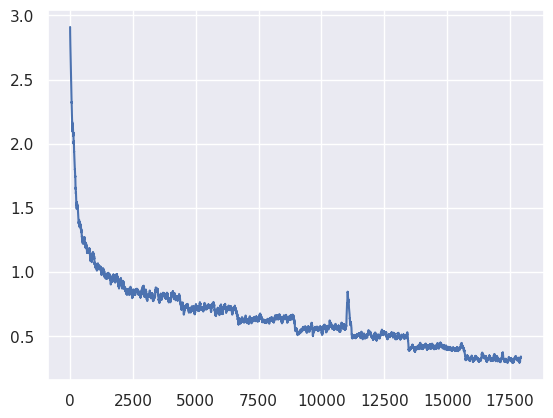

In [25]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [33]:
test_sentence = test_dataset[0]['translation']['vi']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'lo',
    tokenizer = tokenizer,
    # seq_len = model.config.max_length,
    seq_len = max_seq_len,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Đã có thông tin khẳng định rằng tám chú ngựa đua thuần chủng tại Trường đua Randwick ở Sydney đã bị nhiễm cúm ngựa.
Truncated input text: <lao> Đã có thông tin khẳng định rằng tám chú ngựa đua thuần chủng tại Trường đua Randwick ở Sydney đã bị nhiễm cúm ngựa.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [35]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_new_tokens = max_seq_len)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

ມີການຖະແຫຼງການຢືນຢັນວ່າ ງົວແປດໂຕ ທີ່ໂຮງຮຽນການແຂ່ງຂັນ ແຣນນວິດັກ ໃນເມືອງຊິດນີ ຕິດເຊື້ອໄຂ້ຫວັດຫມູ.
ມີການຖະແຫຼງການຢືນຢັນວ່າ ງົວແປດໂຕ ທີ່ໂຮງຮຽນການແຂ່ງຂັນ ແຣນນວິກ ໃນເມືອງຊິດນີ ຕິດເຊື້ອໄຂ້ຫວັດຫມູ.
ມີການຖະແຫຼງການຢືນຢັນວ່າ ງົວແປດໂຕ ທີ່ໂຮງຮຽນການແຂ່ງຂັນ ແຣນນວິກ ໃນຊິດນີ ໄດ້ຖືກຕິດເຊື້ອໄຂ້ຫວັດຫມູ.


In [28]:
#@title Slick Blue Translate
input_text = 'một người lướt sóng gặp phải cá mập' #@param {type:"string"}
output_language = 'lo' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2, max_new_tokens = max_seq_len)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

một người lướt sóng gặp phải cá mập  ->  ຜູ້ຫລິ້ນຄົນຫນື່ງຖືກຈັບກຸມໂດຍປາສະຫຼາມ.
